<a href="https://colab.research.google.com/github/abbasbaraki/abaraki-cc2526/blob/main/DES_melting_Temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import tools

---



---




In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 29.2 MB/s eta 0:00:00


In [2]:
import pandas as pd                                     # Import pandas for data manipulation and analysis
import numpy as np                                      # Import NumPy for numerical operations (e.g., np.nan)
import matplotlib.pyplot as plt                         # Plotting library
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score    # Evaluation metrics

# **RDKit descriptors and Merge**

---



In [3]:
# 1. Imports

from rdkit import Chem                # RDKit core chemistry module (molecules, SMILES parsing)
from rdkit.Chem import Descriptors    # RDKit molecular descriptors (MolWt, TPSA, etc.)


# 2. Load cleaned dataset with SMILES


df = pd.read_csv("Melt_temp_ML.csv")  # Load the pre-cleaned dataset containing SMILES and composition



# 3. Define target variable (melting temperature)


y = df["Tmelt, K"].values         # Extract the target values (melting temperature in Kelvin) as a NumPy array



# 4. Define a set of RDKit descriptor functions


descriptor_funcs = {
    "molwt": Descriptors.MolWt,                          # Molecular weight
    "mollogP": Descriptors.MolLogP,                      # Octanol/water partition coefficient (logP)
    "numHdonors": Descriptors.NumHDonors,                # Number of hydrogen bond donors
    "numHacceptors": Descriptors.NumHAcceptors,          # Number of hydrogen bond acceptors
    "TPSA": Descriptors.TPSA,                            # Topological polar surface area
    "numrotatablebonds": Descriptors.NumRotatableBonds,  # Number of rotatable bonds
    # "ringcount": Descriptors.RingCount,                  # Total ring count in the molecule
    "heavyatomcount": Descriptors.HeavyAtomCount         # Number of non-hydrogen atoms
}



# 5. Helper: convert a SMILES string into descriptor values


def smiles_to_desc(smiles):
    """
    Convert a SMILES string into a dictionary of RDKit descriptors.
    Returns NaNs for all descriptors if the SMILES cannot be parsed.
    """
    mol = Chem.MolFromSmiles(smiles)                             # Parse the SMILES into an RDKit molecule object
    if mol is None:                                              # If parsing failed (invalid SMILES)
        return {k: np.nan for k in descriptor_funcs.keys()}      # Return NaN for each descriptor
    return {k: f(mol) for k, f in descriptor_funcs.items()}      # Compute each descriptor on the molecule and return as dict



# 6. Compute descriptors for each component separately


# For Component #1: apply smiles_to_desc on each SMILES, then expand dicts into columns
desc1 = df["Smiles#1"].apply(smiles_to_desc).apply(pd.Series)

# For Component #2: same procedure as for Component #1
desc2 = df["Smiles#2"].apply(smiles_to_desc).apply(pd.Series)



# 7. Prefix descriptor columns to indicate component origin


desc1 = desc1.add_prefix("c1_")      # Rename columns to start with "c1_" (component 1)
desc2 = desc2.add_prefix("c2_")      # Rename columns to start with "c2_" (component 2)



# 8. Build mixture descriptors: x1 * desc1 + x2 * desc2


X_mix = pd.DataFrame()                # Initialize an empty DataFrame to store mixture-level descriptors

for name in descriptor_funcs.keys():  # Loop over each descriptor name (molwt, TPSA, etc.)
    # Compute a composition-weighted descriptor for the mixture:
    # descriptor_mix = x1 * descriptor_component1 + x2 * descriptor_component2
    X_mix[name + "_mix"] = (
        df["X#1 (molar fraction)"].values * desc1["c1_" + name].values
        + df["X#2 (molar fraction)"].values * desc2["c2_" + name].values
    )


# 9. Select existing descriptor columns from the dataset (non-RDKit, already in CSV)
base_feature_cols = [
    # "MW",
    "HBD_total",
    "X#1 (molar fraction)",
    "X#2 (molar fraction)",
    "fr_Al_COO",
    "fr_Ar_COO",
    "fr_Ar_N",
    "fr_Ar_OH",
    "fr_NH0",
    "fr_NH1",
    "fr_amide",
    "AROM",
    "ALERTS",
    # "n_HM",
]

X_base = df[base_feature_cols].copy()
# 10. Final feature matrix: mixture descriptors + composition fractions

X = pd.concat(
    [X_mix, X_base], axis=1        # Use mixture-level descriptors plus dataset features
)



# 11. Basic checks on the feature matrix

print("X_base shape:", X_base.shape)
print("X_mix shape:", X_mix.shape)
print("Feature matrix shape:", X.shape)                    # Print the shape of the feature matrix (n_samples, n_features)
print("Any missing values in X?", X.isna().any().any())    # Check if there is any NaN in the feature matrix
print(X.head())                                            # Show the first few rows of X for a quick inspection






X_base shape: (2269, 12)
X_mix shape: (2269, 7)
Feature matrix shape: (2269, 19)
Any missing values in X? False
    molwt_mix  mollogP_mix  numHdonors_mix  numHacceptors_mix  TPSA_mix  \
0  146.099990    -4.367402             0.0           0.000000  0.000000   
1  179.102011    -4.936735             0.0           0.000000  0.000000   
2  143.554659    -4.684535             0.0           0.000000  0.000000   
3  186.965669    -5.161968             0.0           0.666666  8.766658   
4  151.418318    -4.909768             0.0           0.666666  8.766658   

   numrotatablebonds_mix  heavyatomcount_mix  HBD_total  X#1 (molar fraction)  \
0               1.333332            5.333331        0.0              0.666667   
1               0.666666            4.666665        0.0              0.666667   
2               0.666666            4.666665        0.0              0.666667   
3               0.999999            5.666664        0.0              0.666667   
4               0.999999        



---



# **Train-Test Split**

---



In [4]:
from sklearn.model_selection import train_test_split    # Import utility to split data into training and testing sets
T_S=0.33
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,                                                  # Split features (X) and target (y) into training and testing subsets
    test_size=T_S,                                     # test_size=0.33 → 33% of the data is reserved for testing
    random_state=42                                     # random_state=42 → ensures reproducible splits across runs
)

print("Train size:", X_train.shape)                     # Print the shape (rows, columns) of the training feature matrix
print("test size:", X_test.shape)                       # Print the shape of the testing feature matrix

Train size: (1520, 19)
test size: (749, 19)




---



## Correlation heatmap (TRAIN ONLY)

---



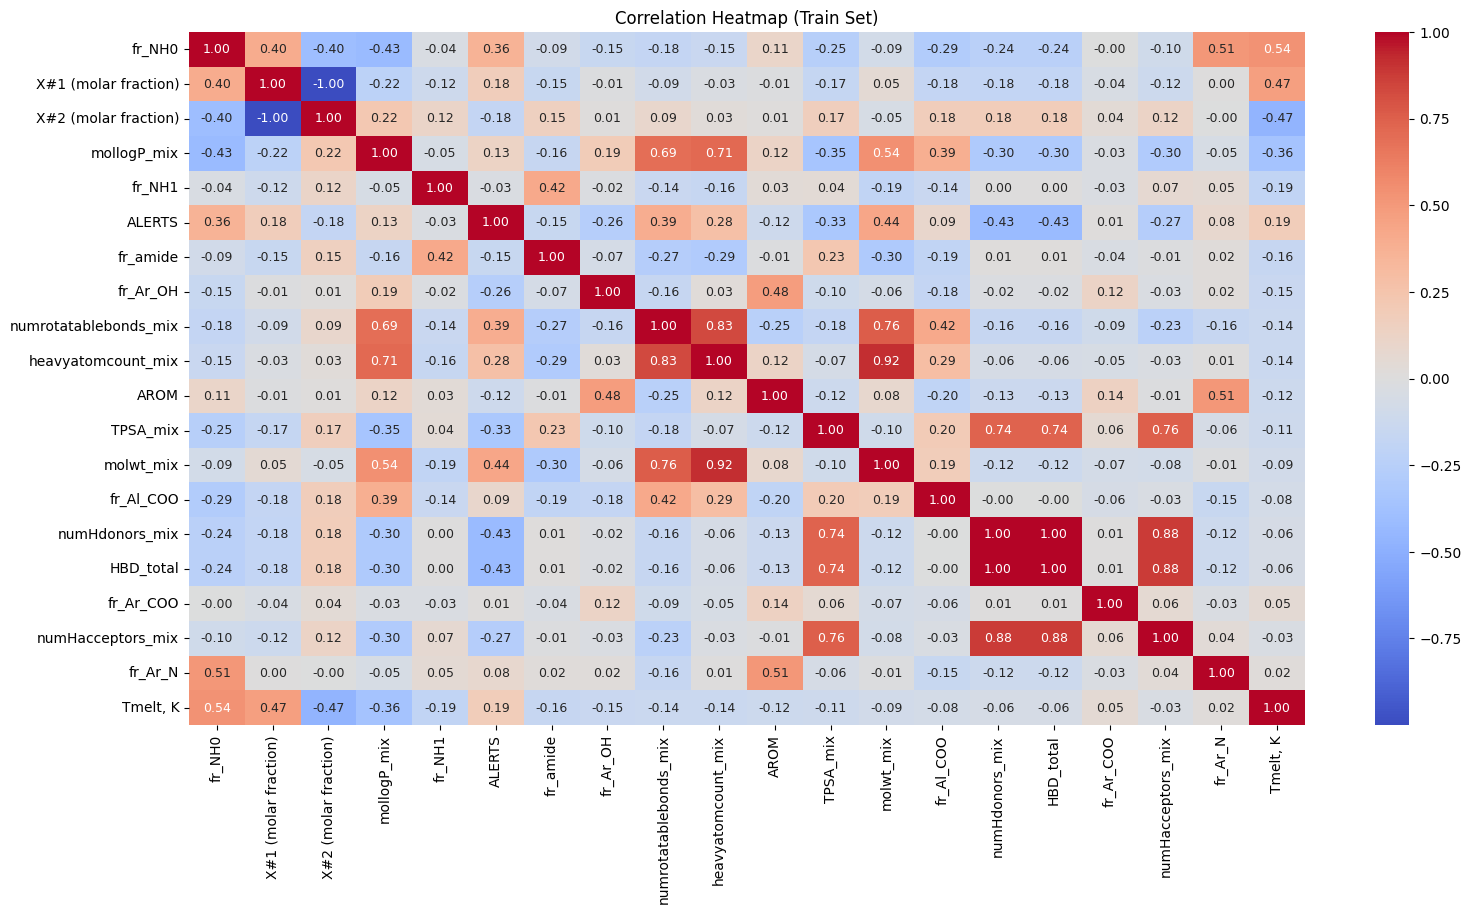

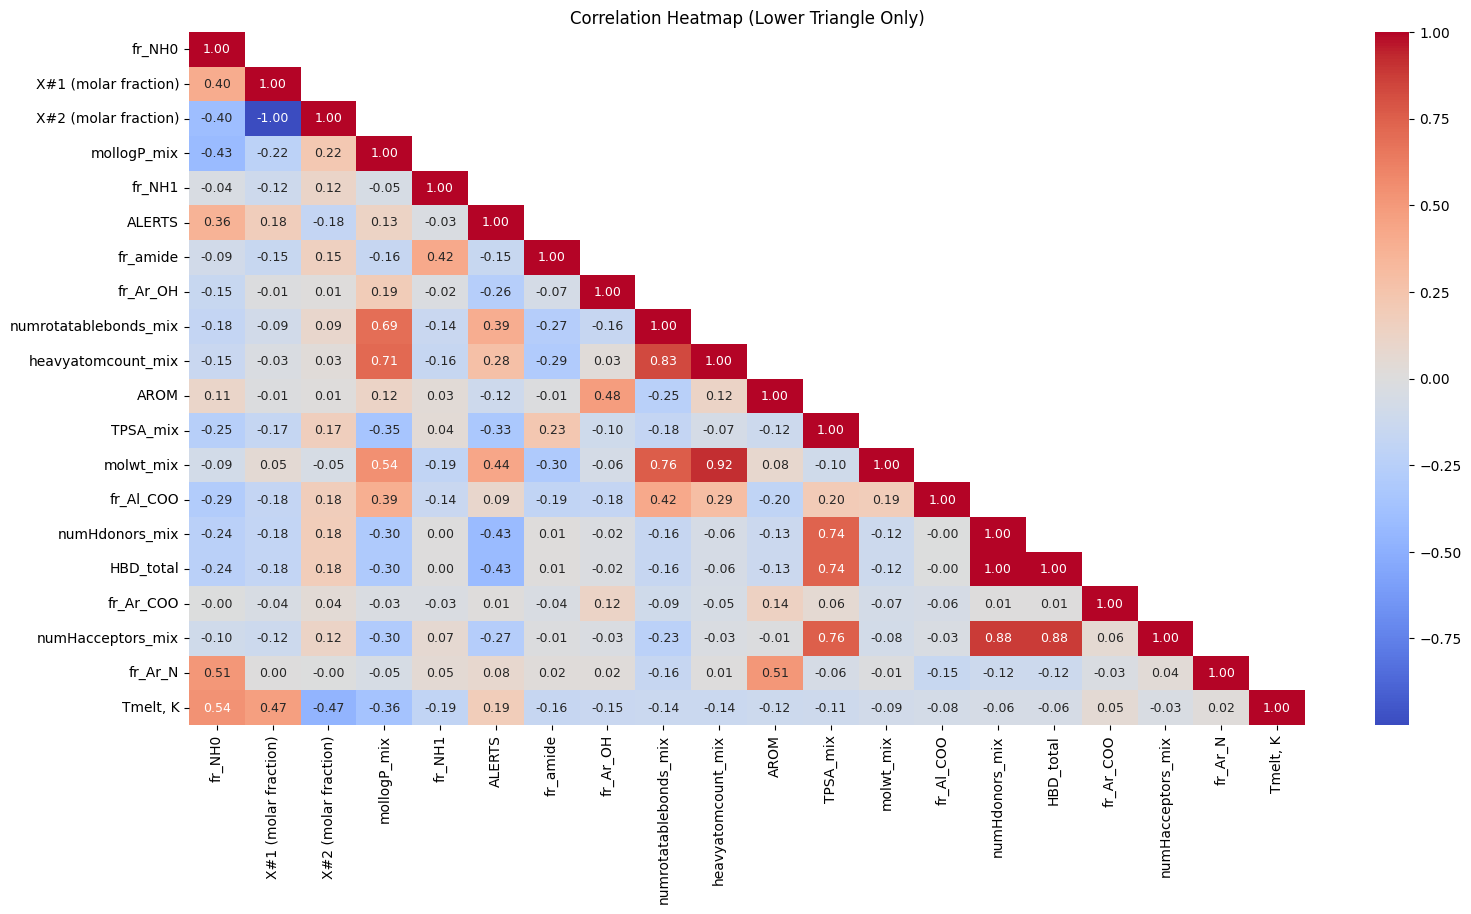

In [23]:
import seaborn as sns                                   # Import seaborn for statistical plotting (especially heatmaps)

train_df = pd.DataFrame(X_train, columns=X.columns)     # Convert the training feature matrix into a pandas DataFrame with column names

train_df["Tmelt, K"] = y_train                          # Add the target variable (melting temperature) as a new column

corr = train_df.corr()                                  # Compute the full correlation matrix between all columns

top = (                                                 # Select the features most strongly correlated with melting temperature

    corr["Tmelt, K"]                    # Take correlations with the target variable
    .drop("Tmelt, K")                   # Remove self-correlation of the target
    .abs()                              # Use absolute values to keep strong negative and positive correlations
    .sort_values(ascending=False)       # Sort correlations from strongest to weakest
    .head(22)                           # Keep only the top 22 correlated features
    .index                              # Extract feature names
    .tolist()                           # Convert index to a Python list
)


cols = top + ["Tmelt, K"]                               # Create a list of selected features plus the target column
corr_top = train_df[cols].corr()                        # Store the correlation matrix of selected columns

# PLOT THE FULL CORRELATION HEAT-MAP

plt.figure(figsize=(18, 9))                             # Create a large figure for the full heatmap
# Plot the full correlation heatmap with annotations
sns.heatmap(corr_top, annot=True, annot_kws={"size":9}, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Train Set)")            # Add a title to the plot
plt.show()                                              # Display the plot


mask = np.triu(np.ones_like(corr_top, dtype=bool), k=1) # Create a mask to hide the upper triangle of the correlation matrix

# PLOT THE ONLY LOWER TRIANGLE OF CORRELATION HEAT-MAP

plt.figure(figsize=(18, 9))                             # Create a large figure for the lower-triangle heatmap
sns.heatmap(corr_top, mask=mask, annot=True, annot_kws={"size":9}, cmap="coolwarm", fmt=".2f")  # Plot the heatmap
plt.title("Correlation Heatmap (Lower Triangle Only)")  # Add a title to the plot
plt.show()                                              # Display the plot




---



# STANDARDIZATION

---



In [6]:
# Feature scaling

from sklearn import preprocessing               # Import preprocessing utilities (scaling, normalization, etc.)

scaler = preprocessing.StandardScaler()         # Create a StandardScaler (z-score scaling: mean=0, std=1)

scaler.fit(X_train)                             # Fit the scaler on the training data ONLY (learn mean and std from training set)

X_train = scaler.transform(X_train)             # Apply the learned scaling parameters to both train and test data
X_test = scaler.transform(X_test)               # fitting on the test set may cause data leakage




---





# ***MODELS***


---


---



1.   Linear Regression

1.   Ridge Regression
2.   KRR


2.   Random Forest

---





---



# Linear Regression

---



In [7]:
from sklearn.linear_model import LinearRegression                     # Linear regression model

# Initialize Linear Regression model
lin_reg = LinearRegression()                                          # Create an instance of a linear regression model

# Train the model on the training data (learn coefficients)
lin_reg.fit(X_train, y_train)                                         # Fit model: finds best linear relationship between X and y

# Predict on the test set
y_pred_lin = lin_reg.predict(X_test)                                  # Generate predictions for unseen test data

# Evaluate predictions using common regression metrics
mae_lin = mean_absolute_error(y_test, y_pred_lin)                     # Average absolute difference between true and predicted
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))            # Square-root of MSE: penalizes large errors
r2_lin = r2_score(y_test, y_pred_lin)                                 # R^2: proportion of variance explained by the model

print("Linear Regression MAE (K):", mae_lin)                          # Print MAE in Kelvin
print("Linear Regression RMSE (K):", rmse_lin)                        # Print RMSE in Kelvin
print("Linear Regression R2:", r2_lin)                                # Print R2 score



Linear Regression MAE (K): 37235.89489699909
Linear Regression RMSE (K): 1017778.5613864254
Linear Regression R2: -181168888.19924942


## LinearRegression PLOT

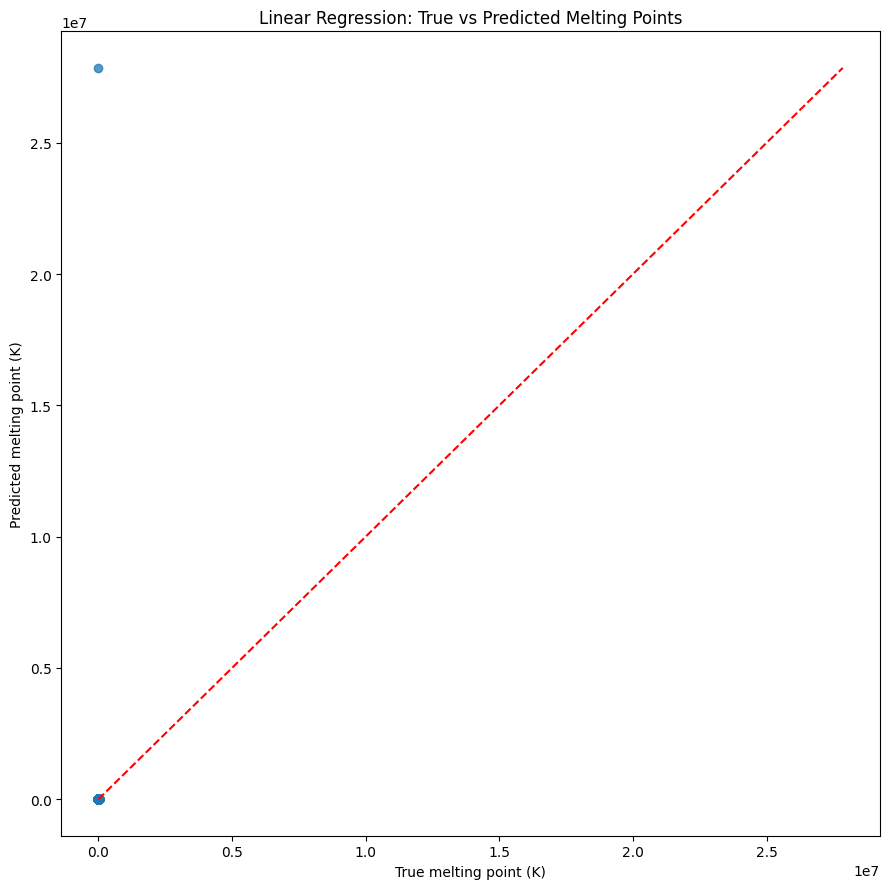

In [8]:
# Scatter plot: true vs predicted values
plt.figure(figsize=(9, 9))                           # Create a square plotting figure

# Scatter plot of true vs predicted melting points
plt.scatter(y_test, y_pred_lin, alpha=0.75)          # Each point represents one test sample

# Ideal prediction line (y = x)
min_val = min(y_test.min(), y_pred_lin.min())        # Minimum value across both arrays
max_val = max(y_test.max(), y_pred_lin.max())        # Maximum value across both arrays
plt.plot([min_val, max_val],                         # x-coordinates
         [min_val, max_val],                         # y-coordinates
         "r--")                                      # Red dashed identity line

# Axis labels and title
plt.xlabel("True melting point (K)")                 # Label x-axis
plt.ylabel("Predicted melting point (K)")            # Label y-axis
plt.title("Linear Regression: True vs Predicted Melting Points")

plt.tight_layout()                                   # Prevent overlap of labels
plt.show()                                           # Display the plot



---



# RIDGE

---



In [9]:
from sklearn.linear_model import Ridge                                          # Ridge regression (L2-regularized linear regression)

# Create a baseline Ridge regression model (alpha controls regularization strength)
ridge = Ridge(alpha=10000.0)                                         # Larger alpha → stronger penalty on large coefficients

# Train the model on the training data
ridge.fit(X_train, y_train)                                      # Fit: learns coefficients under L2 regularization

# Predict on the test set
y_pred_rid = ridge.predict(X_test)                                   # Generate predictions on unseen data

# Evaluate model performance
mae_rid = mean_absolute_error(y_test, y_pred_rid)                        # Mean absolute error
rmse_rid = np.sqrt(mean_squared_error(y_test, y_pred_rid))               # Root mean squared error
r2_rid = r2_score(y_test, y_pred_rid)                                    # R^2 score (variance explained)

print("RIDGE MAE (K):", mae_rid)                                     # Print MAE in Kelvin
print("RIDGE RMSE (K):", rmse_rid)                                   # Print RMSE
print("RIDGE R2:", r2_rid)                                           # Print R^2 score

RIDGE MAE (K): 60.85797358148133
RIDGE RMSE (K): 260.4915294255103
RIDGE R2: -10.867636499418325


## Ridge PLOT

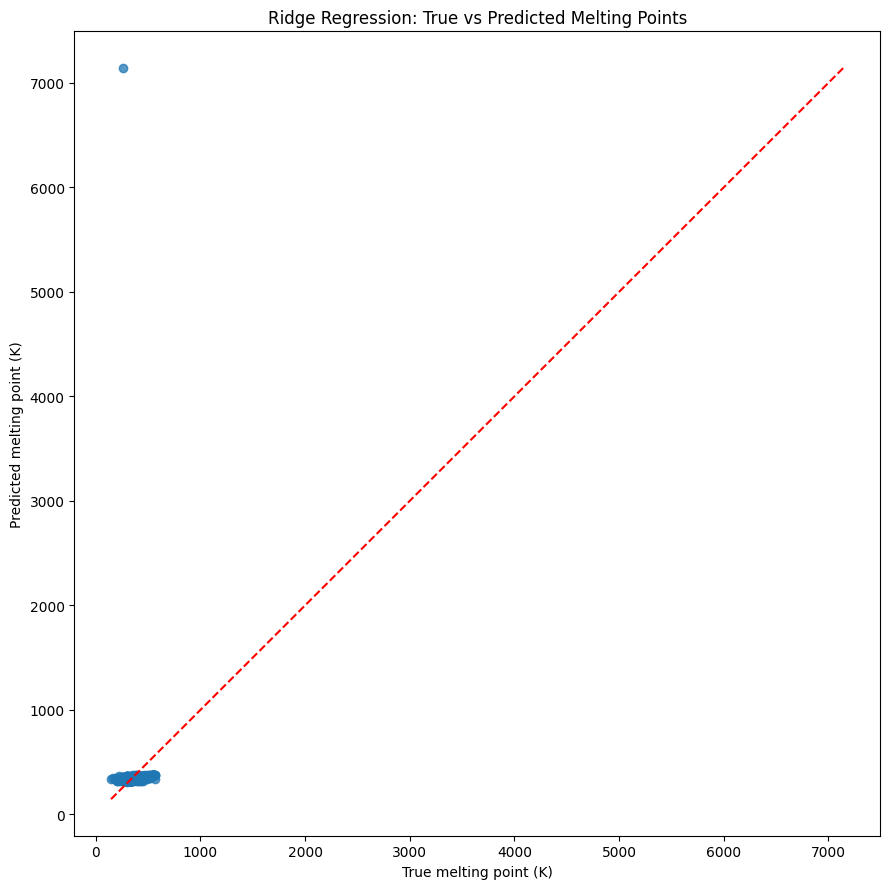

In [10]:
# Scatter plot: true vs predicted values
plt.figure(figsize=(9, 9))                           # Create a square plotting figure

# Scatter plot of true vs predicted melting points
plt.scatter(y_test, y_pred_rid, alpha=0.75)          # Each point represents one test sample

# Ideal prediction line (y = x)
min_val = min(y_test.min(), y_pred_rid.min())        # Minimum value across both arrays
max_val = max(y_test.max(), y_pred_rid.max())        # Maximum value across both arrays
plt.plot([min_val, max_val],                         # x-coordinates
         [min_val, max_val],                         # y-coordinates
         "r--")                                      # Red dashed identity line

# Axis labels and title
plt.xlabel("True melting point (K)")                 # Label x-axis
plt.ylabel("Predicted melting point (K)")            # Label y-axis
plt.title("Ridge Regression: True vs Predicted Melting Points")

plt.tight_layout()                                   # Prevent overlap of labels
plt.show()                                           # Display the plot



---



# Kernel Ridge Regression

---





In [11]:
from sklearn.kernel_ridge import KernelRidge                 # Kernel Ridge Regression model

# Initialize Kernel Ridge Regression
krr = KernelRidge(
    kernel="rbf",                                            # RBF kernel allows nonlinear relationships
    alpha=0.1,                                               # Regularization strength (like Ridge)
    gamma=0.1                                                # Controls RBF kernel width (model flexibility)
)

# Train the model on the training data
krr.fit(X_train, y_train)                                    # Fit KRR in kernel space

# Predict on the test set
y_pred_krr = krr.predict(X_test)                             # Generate predictions for unseen data

# Evaluate performance
mae_krr = mean_absolute_error(y_test, y_pred_krr)            # Mean absolute error
rmse_krr = np.sqrt(mean_squared_error(y_test, y_pred_krr))   # Root mean squared error
r2_krr = r2_score(y_test, y_pred_krr)                        # R^2 score (variance explained)

print("KRR MAE (K):", mae_krr)
print("KRR RMSE (K):", rmse_krr)
print("KRR R2:", r2_krr)

KRR MAE (K): 20.960160887784237
KRR RMSE (K): 37.73520778252648
KRR R2: 0.7509591925574121


## KRR PLOT

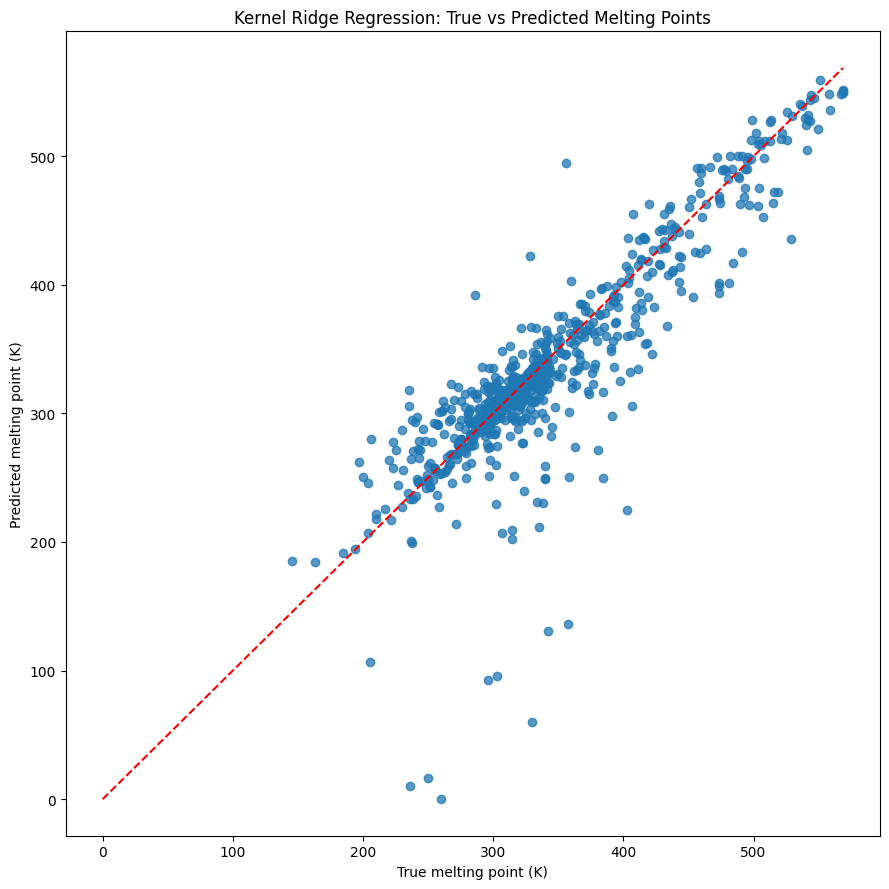

In [12]:
# Scatter plot: true vs predicted values
plt.figure(figsize=(9, 9))                           # Create a square plotting figure

# Scatter plot of true vs predicted melting points
plt.scatter(y_test, y_pred_krr, alpha=0.75)          # Each point represents one test sample

# Ideal prediction line (y = x)
min_val = min(y_test.min(), y_pred_krr.min())        # Minimum value across both arrays
max_val = max(y_test.max(), y_pred_krr.max())        # Maximum value across both arrays
plt.plot([min_val, max_val],                         # x-coordinates
         [min_val, max_val],                         # y-coordinates
         "r--")                                      # Red dashed identity line

# Axis labels and title
plt.xlabel("True melting point (K)")                 # Label x-axis
plt.ylabel("Predicted melting point (K)")            # Label y-axis
plt.title("Kernel Ridge Regression: True vs Predicted Melting Points")

plt.tight_layout()                                   # Prevent overlap of labels
plt.show()                                           # Display the plot



---



# Random Forest Regression

---



In [13]:
from sklearn.ensemble import RandomForestRegressor                 # Tree-based ensemble regression model

# Initialize Random Forest model
rf = RandomForestRegressor(
    n_estimators=500,                                              # Number of trees in the forest
    random_state=42,                                               # Reproducible results
    n_jobs=-1                                                      # Use all CPU cores for faster training
)

# Train the model on the training set
rf.fit(X_train, y_train)                                           # Build many decision trees using training data

# Predict on the test set
y_pred_rf = rf.predict(X_test)                                     # Average predictions from all trees

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)                    # Mean absolute error
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))           # Root mean squared error
r2_rf = r2_score(y_test, y_pred_rf)                                # R^2 performance score

print("RF MAE (K):", mae_rf)
print("RF RMSE (K):", rmse_rf)
print("RF R2:", r2_rf)

RF MAE (K): 18.21328594003432
RF RMSE (K): 29.70463178076838
RF R2: 0.8456788785040812


## RF Feature Importance

In [14]:
# Random Forest Feature Importance
# Extract feature importances from the trained Random Forest model
importances = rf.feature_importances_         # Importance score for each feature (how much each feature helped reduce error)

# Get the feature names from X
feature_names = X.columns                     # Column names corresponding to each importance value

# Build a DataFrame combining feature names and their importance scores
feat_imp = pd.DataFrame({
    "Feature": feature_names,                 # Feature name
    "importance": importances                 # Importance value from the model
}).sort_values("importance", ascending=False) # Sort features by importance (highest first)

# Display ranked feature importance table
print(feat_imp)

                  Feature  importance
14                 fr_NH0    0.441975
6      heavyatomcount_mix    0.103036
0               molwt_mix    0.065134
9    X#2 (molar fraction)    0.058401
3       numHacceptors_mix    0.039018
1             mollogP_mix    0.037441
8    X#1 (molar fraction)    0.035438
4                TPSA_mix    0.033535
17                   AROM    0.026315
10              fr_Al_COO    0.026021
7               HBD_total    0.025005
2          numHdonors_mix    0.024722
5   numrotatablebonds_mix    0.021612
18                 ALERTS    0.020146
12                fr_Ar_N    0.013447
13               fr_Ar_OH    0.010018
15                 fr_NH1    0.009152
11              fr_Ar_COO    0.004921
16               fr_amide    0.004662


# RF PLOT

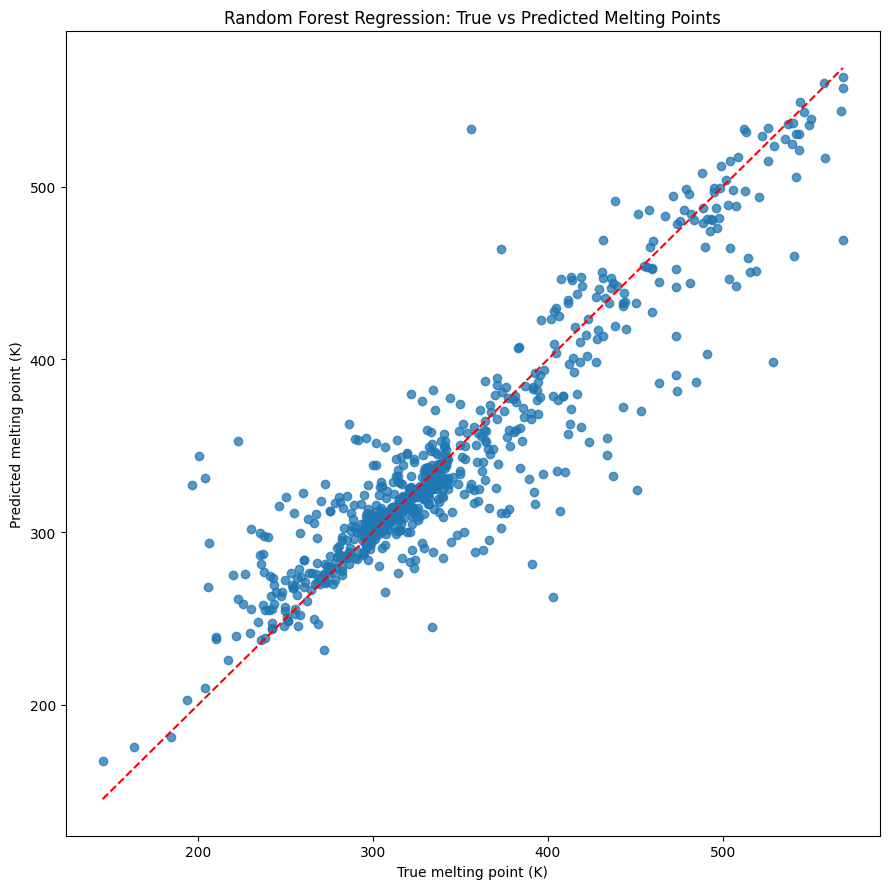

In [15]:
# Scatter plot: true vs predicted values
plt.figure(figsize=(9, 9))                           # Create a square plotting figure

# Scatter plot of true vs predicted melting points
plt.scatter(y_test, y_pred_rf, alpha=0.75)          # Each point represents one test sample

# Ideal prediction line (y = x)
min_val = min(y_test.min(), y_pred_rf.min())        # Minimum value across both arrays
max_val = max(y_test.max(), y_pred_rf.max())        # Maximum value across both arrays
plt.plot([min_val, max_val],                         # x-coordinates
         [min_val, max_val],                         # y-coordinates
         "r--")                                      # Red dashed identity line

# Axis labels and title
plt.xlabel("True melting point (K)")                 # Label x-axis
plt.ylabel("Predicted melting point (K)")            # Label y-axis
plt.title("Random Forest Regression: True vs Predicted Melting Points")

plt.tight_layout()                                   # Prevent overlap of labels
plt.show()                                           # Display the plot



---





---



---
# **COMPARISON**

---



---








In [16]:
results = pd.DataFrame({
    "Model": ["Linear regression", "Ridge Regression", "Kernel Ridge (RBF)", "Random Forest"],
    "MAE (K)": [mae_lin, mae_rid, mae_krr, mae_rf],
    "RMSE (K)": [rmse_lin, rmse_rid, rmse_krr, rmse_rf],
    "R2": [r2_lin, r2_rid, r2_krr, r2_rf]
})

results = results.round(2)
test_train = ["Test% =", "{:0.2g}".format(T_S*100), "Train% =",  "{:0.2g}".format((1 - T_S)*100)]

print(results)
print(test_train) # test/train size

                Model   MAE (K)    RMSE (K)            R2
0   Linear regression  37235.89  1017778.56 -1.811689e+08
1    Ridge Regression     60.86      260.49 -1.087000e+01
2  Kernel Ridge (RBF)     20.96       37.74  7.500000e-01
3       Random Forest     18.21       29.70  8.500000e-01
['Test% =', '33', 'Train% =', '67']




---

